In [1]:
import pickle
from detectors import *
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
def time_fit(det, data):
    time_begin = time.time()
        
    det = det.fit(np.array(data))
    
    return det, time.time() - time_begin

def time_test(det, data):
    time_begin = time.time()
        
    result = det.predict_proba(np.array(data))
    
    return det, time.time() - time_begin, result


# load data

In [3]:
modes = ['bert_768', 'bow_50', 'bow_768']
subsets = {}

result_pickle = 'data/results/twitter_diff_dist.pickle'

for mode in modes:
    with open('data/twitter/twitter_{mode}_diff_dist.pickle'.format(mode=mode), 'rb') as handle:
        subsets[mode] = pickle.load(handle)


# initiate detectors

In [4]:
detectors = {
    'csdd': CosineSimilarityDriftDetector(),
    'kts' : KernelTwoSampleDriftDetector(),
    'aks' : AlibiKSDetector(),
    'ammd': AlibiMMDDetector()
}

# tests

In [5]:

if os.path.isfile(result_pickle):  # Do not overwrite
    print('Loading result pickle: ', result_pickle)
    with open(result_pickle, 'rb') as handle:
        results_124, results_192, results_480 = pickle.load(handle)
else:
    results_124 = {mode: {detector: {} for detector in detectors} for mode in modes}
    results_192 = {mode: {detector: {} for detector in detectors} for mode in modes}
    results_480 = {mode: {detector: {} for detector in detectors} for mode in modes}

for detector in detectors:
    for mode in modes:
        if not detector in results_124[mode]:
            results_124[mode][detector] = {}
            results_192[mode][detector] = {}
            results_480[mode][detector] = {}
        if 'predictions' in results_124[mode][detector]: # skip already computed
            continue
        
        results_124[mode][detector]['predictions'] = []
        results_192[mode][detector]['predictions'] = []
        results_480[mode][detector]['predictions'] = []
        
        results_124[mode][detector]['time_detect'] = []
        
        for permutation_num in range(8):
            det, t = time_fit(detectors[detector], subsets[mode]['100'][0][permutation_num])
            results_124[mode][detector]['time_fit'] = t
            
            permutation_124 = subsets[mode]['124'][0][permutation_num]
            det_2, t, res = time_test(det, permutation_124)
            results_124[mode][detector]['predictions'].append(res)
            results_124[mode][detector]['time_detect'].append(t)
            
            permutation_192 = subsets[mode]['192'][0][permutation_num]
            det_2, t, res = time_test(det, permutation_192)
            results_192[mode][detector]['predictions'].append(res)
            
            permutation_480 = subsets[mode]['480'][0][permutation_num]
            det_2, t, res = time_test(det, permutation_480)
            results_480[mode][detector]['predictions'].append(res)

with open(result_pickle, 'wb') as handle:
    pickle.dump((results_124, results_192, results_480), handle)


Loading result pickle:  data/results/twitter_diff_dist.pickle


# plot graphs TODO

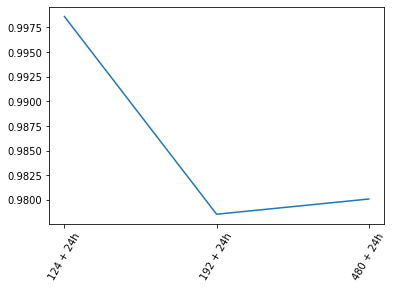

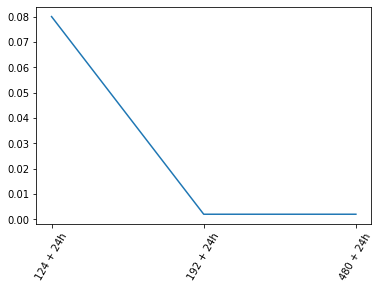

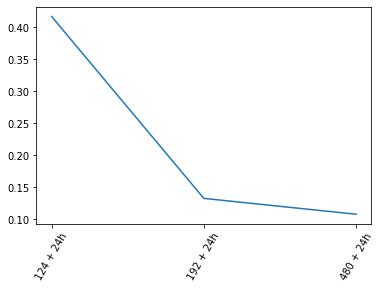

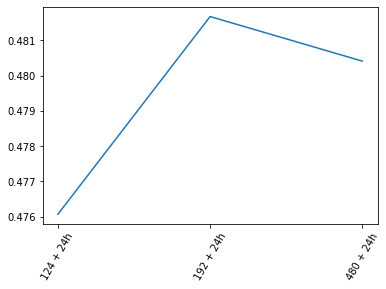

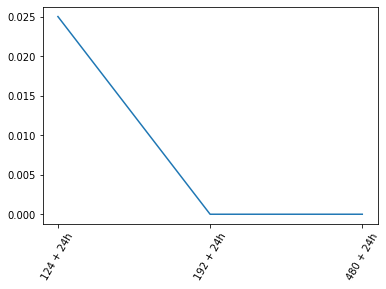

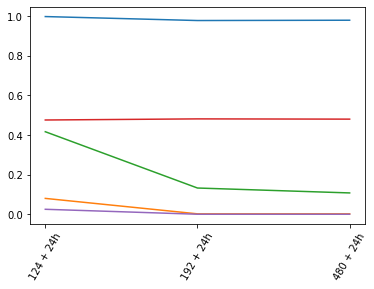

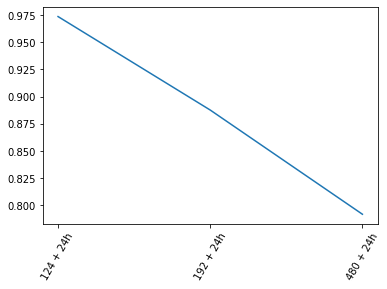

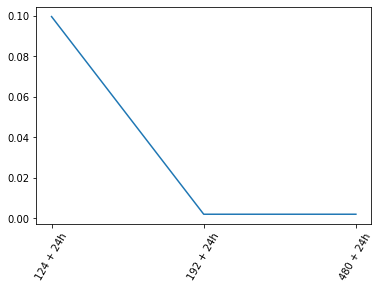

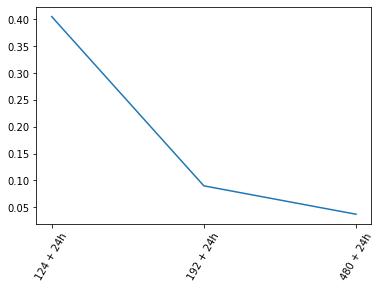

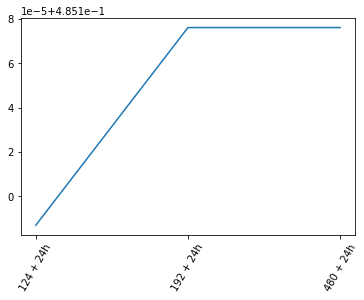

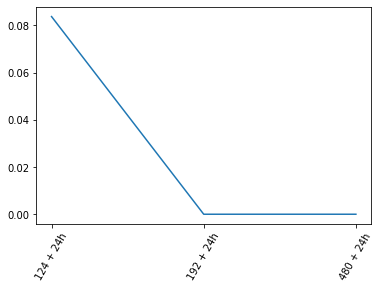

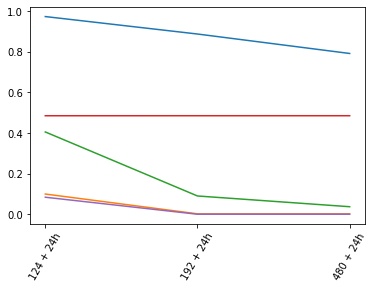

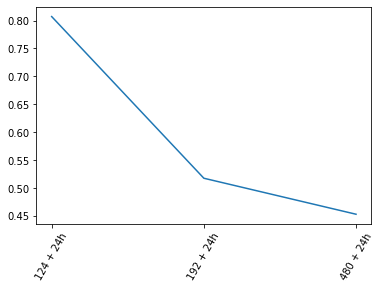

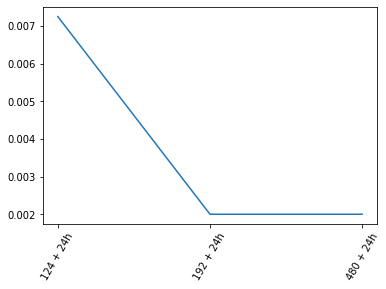

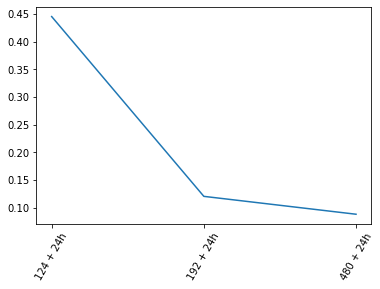

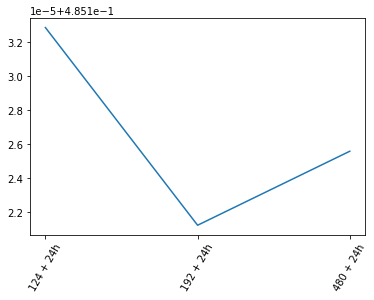

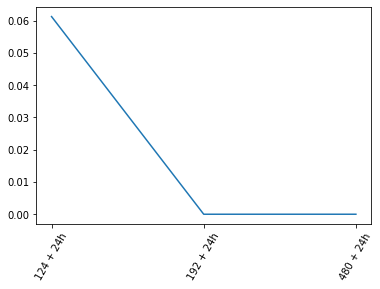

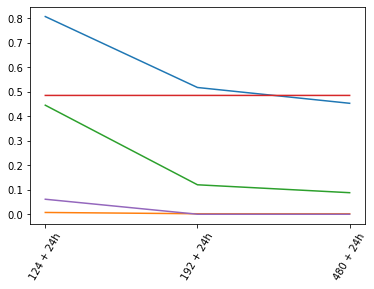

In [9]:
for mode in modes:
    for detector in detectors:
        res = [np.mean(r[mode][detector]['predictions']) for r in (results_124, results_192, results_480)]
        plt.plot(res)
        plt.xticks(ticks=range(0,3), labels=['124 + 24h', '192 + 24h', '480 + 24h'], rotation=60)
        plt.savefig('figures/by_dataset/twitter_{mode}_diff_dist_{detector}.pdf'.format(mode=mode, detector=detector), format='pdf')
        plt.show()
    for detector in detectors:
        res = [np.mean(r[mode][detector]['predictions']) for r in (results_124, results_192, results_480)]
        plt.plot(res)
    plt.xticks(ticks=range(0,3), labels=['124 + 24h', '192 + 24h', '480 + 24h'], rotation=60)
    plt.savefig('figures/by_dataset/twitter_{mode}_diff_dist_all.pdf'.format(mode=mode), format='pdf')
    plt.show()
